In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

### Data cleaning

Some useful functions

In [3]:
def plot_feature_graphs(y, x, labels, n_per_line):
    """plot scatter graphs of the features (used to visualize which regression method would be best)"""
    #colors = ['blue' if y[i] == 1 else 'green' for i in range(y.shape[0])]
    figsize_x = (n_per_line + 1) * n_per_line
    figsize_y = (n_per_line + 1) * (len(x.T) / n_per_line)
    fig = plt.figure(figsize=(figsize_x, figsize_y))
    ax_ls = []
    for ind, col in enumerate(x.T):
        k = int(ind / n_per_line)
        i = ind % n_per_line
        ax_ls.append(plt.subplot2grid((n_per_line + 1, n_per_line + 1), (k, i)))
        ax_ls[ind].scatter(x.T[ind], y) #c=colors)
        ax_ls[ind].set_xlabel(labels[ind])
    plt.show()


def plot_feature_boxplots(data, labels, n_per_line):
    """plot boxplots of values for all features (useful to study their distributions)"""
    figsize_x = (n_per_line + 1) * n_per_line
    figsize_y = (n_per_line + 1) * (len(data.T) / n_per_line)
    fig = plt.figure(figsize=(figsize_x, figsize_y))
    ax_ls = []
    for ind, col in enumerate(data.T):
        k = int(ind / n_per_line)
        i = ind % n_per_line
        ax_ls.append(plt.subplot2grid((n_per_line + 1, n_per_line + 1), (k, i)))
        ax_ls[ind].boxplot(data=data.T, x=data.T[ind])
        ax_ls[ind].set_xlabel(labels[ind])
    plt.show()


def plot_histograms(data, labels, n_per_line):
    """plot histogram of all features in data"""
    figsize_x = (n_per_line + 1) * n_per_line 
    figsize_y = (n_per_line + 1) * (len(data.T) / n_per_line)
    fig = plt.figure(figsize=(figsize_x, figsize_y))
    for ind, col in enumerate(data.T):
        k = int(ind / n_per_line)
        i = ind % n_per_line
        plt.subplot2grid((n_per_line + 1, n_per_line + 1), (k, i))
        plt.hist(col, bins='auto')
        plt.title(labels[ind])
    plt.show()


In [4]:
# Get label names
labels = []
with open('../data/train.csv', 'r') as f:
    labels = f.readline().rstrip()
labels = labels.split(',')[2:] # remove first two columns (which are ID and prediction respectively)
print(len(labels))

lab_dict = {}
for ind, lab in enumerate(labels):
    lab_dict.update({lab: ind})

30


Get an idea of the distribution of the data:

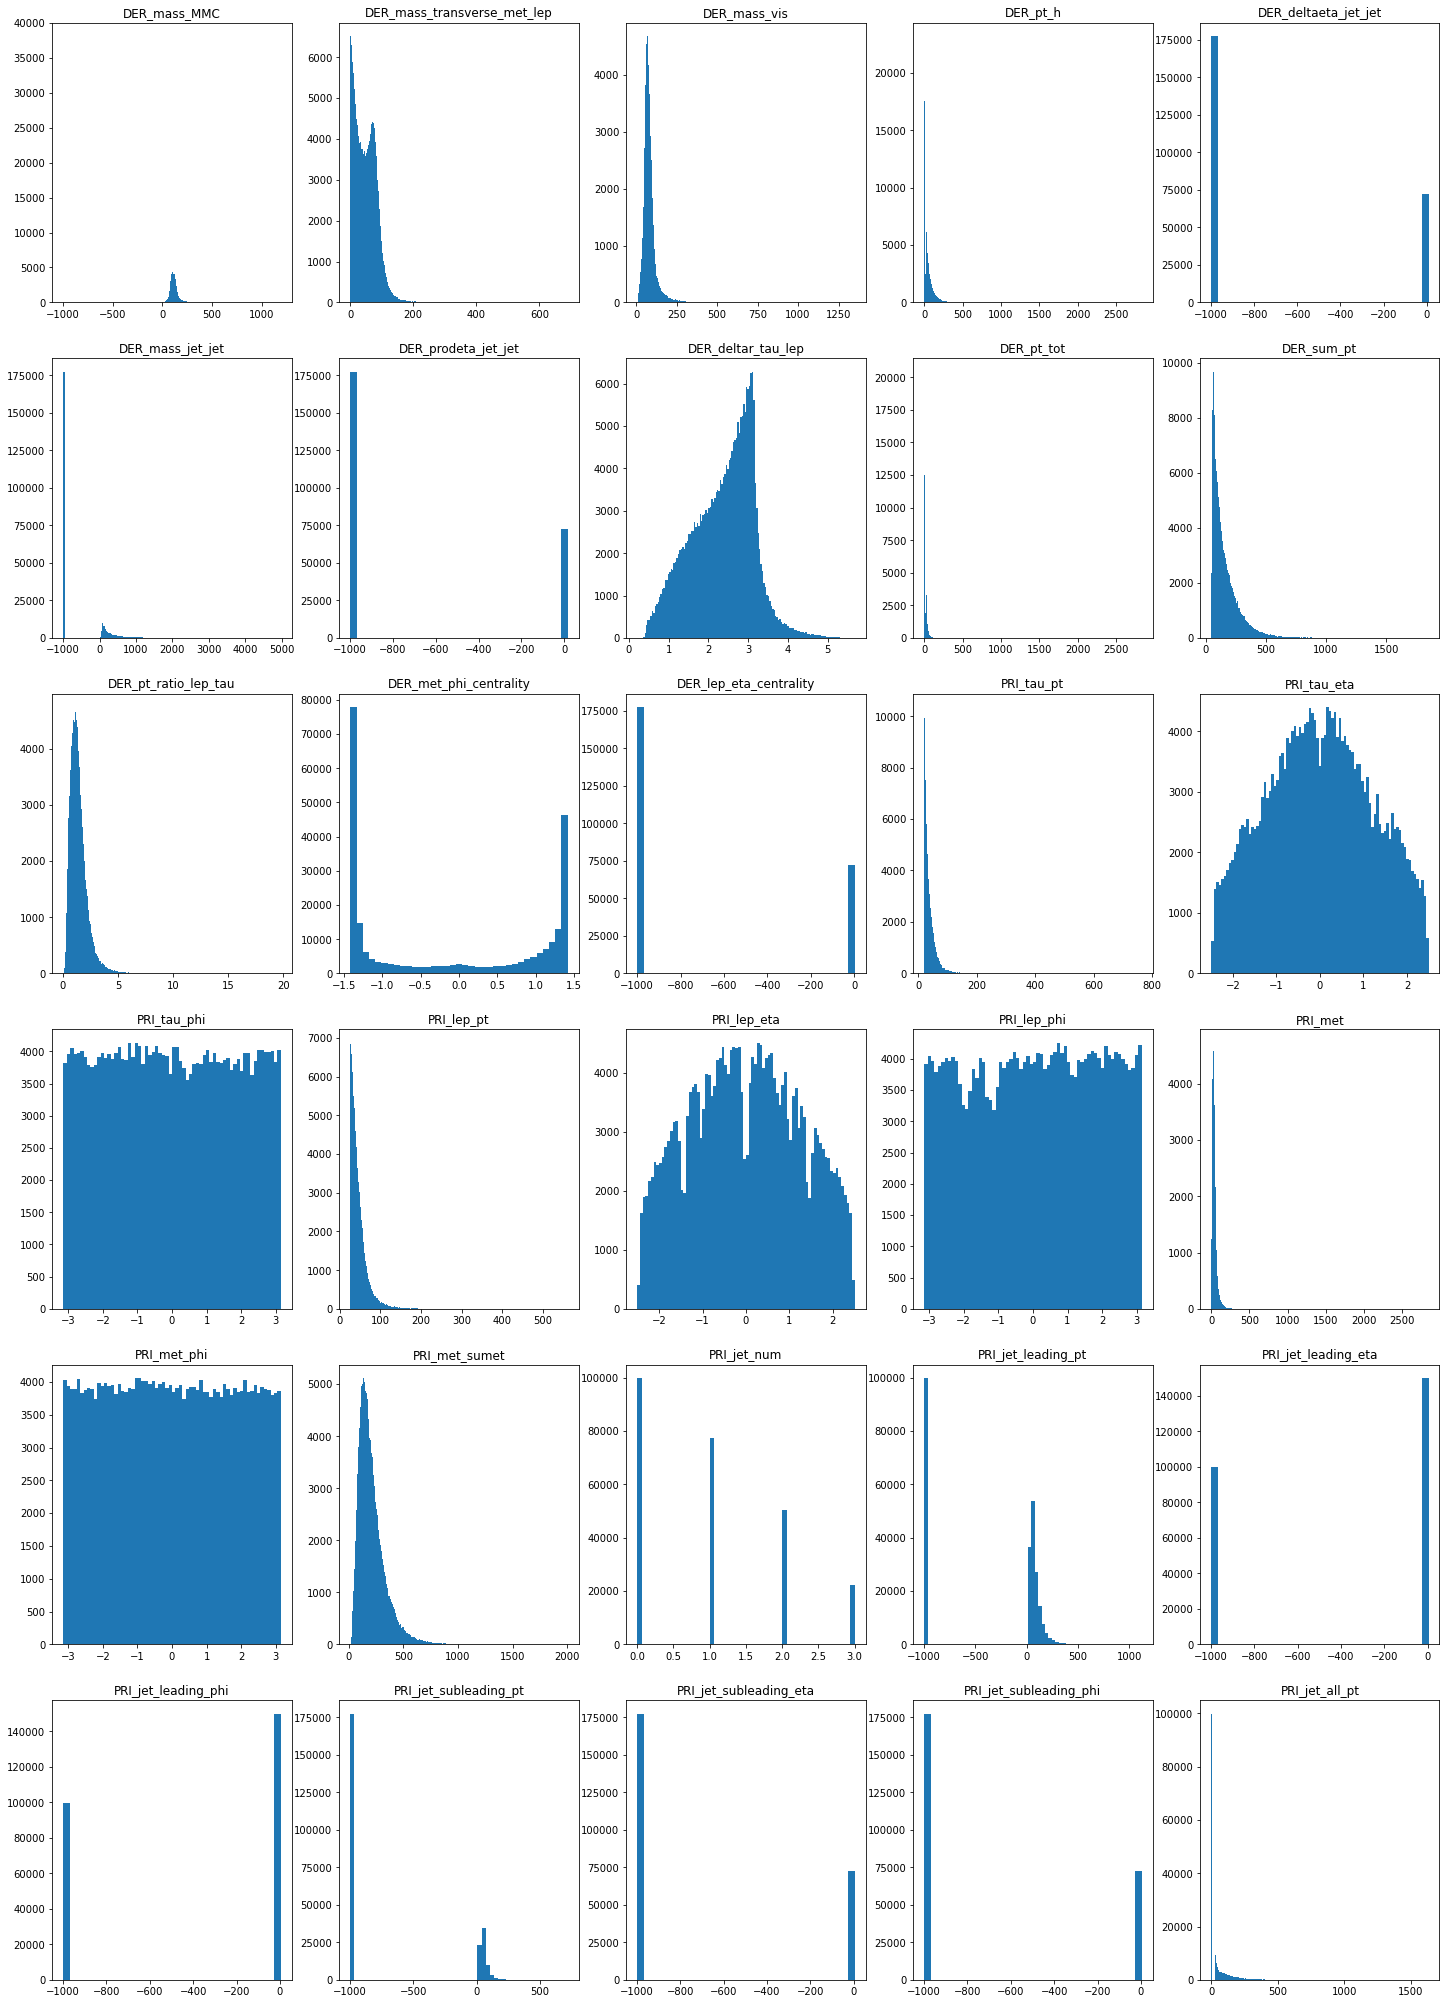

In [5]:
plot_histograms(tX, labels, 5)

We notice that many of these histograms have many elements with the value `-999.0`. This corresponds to the in-dataset NaN value, i.e. missing values. Furthermore, the `PRI_jet_num` feature is discrete, and divides the dataset into 4 categories. <br>This could be useful for classifying signal vs background datapoints more accurately. For instance, we could split the dataset into 4 categories, and train 4 different models on the data. Then, given a test set, we could split the set similarly and perform predictions using the appropriate model. <br>
> Furthermore, we may be able to clean the data (i.e. replacing missing values with plausible ones) more easily, given more precise distributions entailed by a more specific subset of the data. (or not)

#### Splitting the data into categories

In [6]:
jet_cat = [0, 1, 2, 3]

def split_data_by_jet_num(tx, y=None):
    y_cats = []
    tx_cats = []
    for i in jet_cat:
        indexes = np.where(tx[:, lab_dict['PRI_jet_num']] == i)
        if (y is not None):
            y_cats.append(y[indexes])
        tx_cats.append(tx[indexes])

    return y_cats, tx_cats
    
y_cats, tx_cats = split_data_by_jet_num(tX, y)


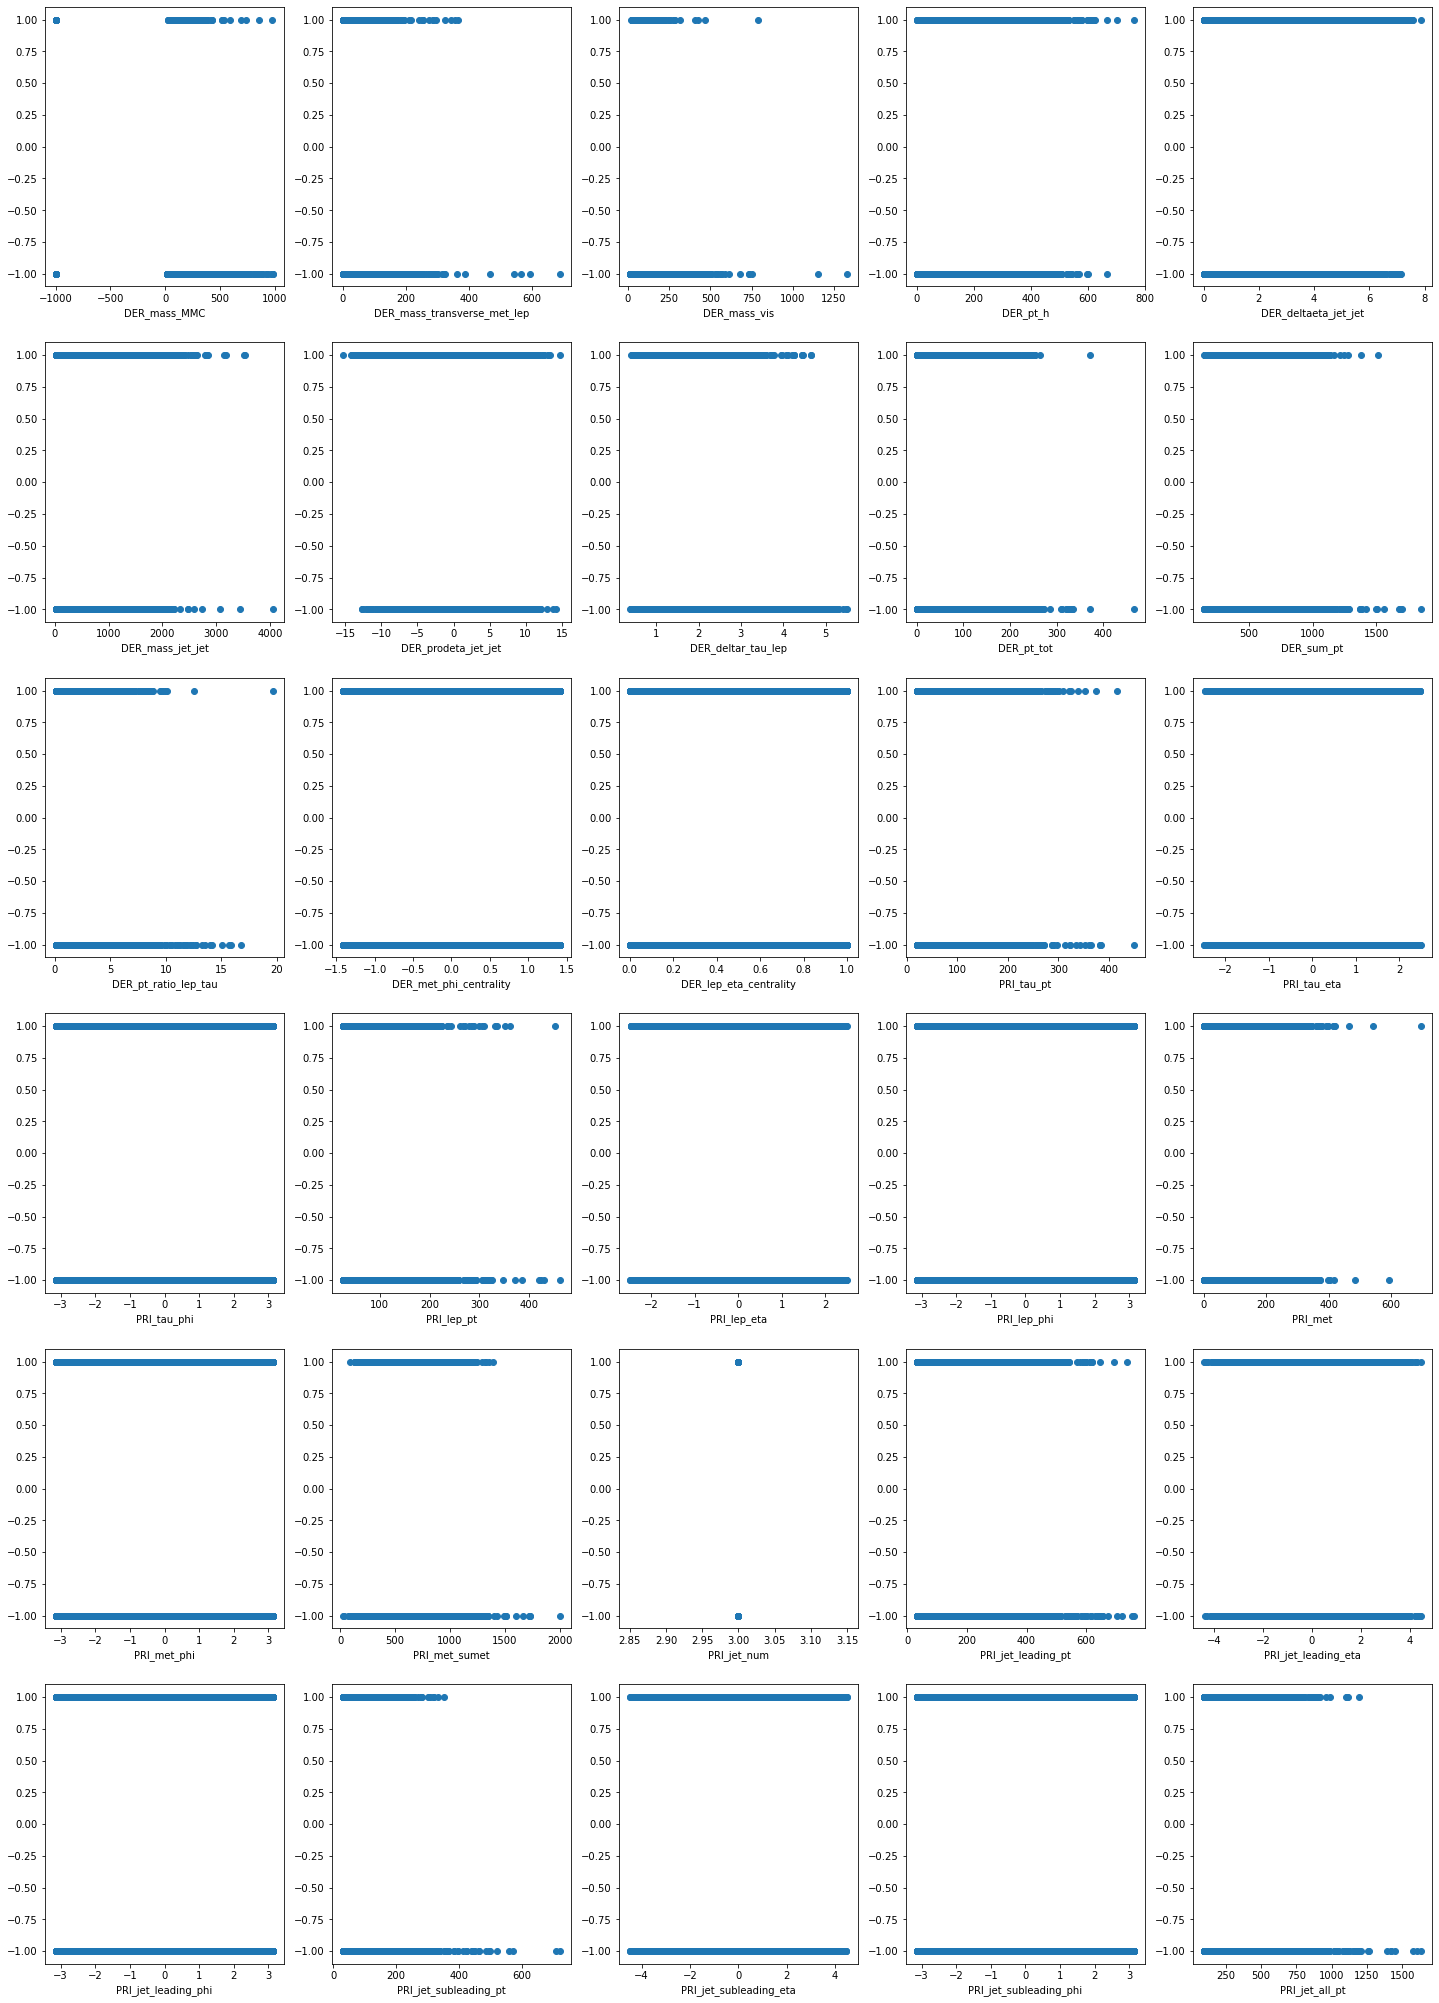

In [7]:
plot_feature_graphs(y_cats[3], tx_cats[3], labels, 5)

From the above plots, we notice that when divided into categories, some features become irrelevant to classification (i.e. they all have the same value, which can furthermore be `-999.0`). Therefore, it might be more appropriate to preprocess the data by selecting the appropriate features before beginning training or predictions.

In [8]:
irrelevant_features = {
    0: ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_num',
        'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta',
        'PRI_jet_subleading_phi', 'PRI_jet_all_pt'],
    1: ['DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_lep_eta_centrality', 'PRI_jet_num',
        'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi'],
    2: ['PRI_jet_num'],
    3: ['PRI_jet_num']
}


In [9]:
# Get irrelevant feature indexes
ir_ind = {}
for k in irrelevant_features.keys():
    ir_ind.update({k: []})
    for v in irrelevant_features[k]:
        ir_ind[k].append(lab_dict[v])

# Get relevant feature indexes
all_indexes = np.array(list(range(len(labels))))
rel_ind = {}
for k in ir_ind.keys():
    rel_ind.update({k: list(np.delete(all_indexes, ir_ind[k]))})

print(ir_ind)
print(rel_ind)

{0: [4, 5, 6, 12, 22, 23, 24, 25, 26, 27, 28, 29], 1: [4, 5, 6, 12, 22, 26, 27, 28], 2: [22], 3: [22]}
{0: [0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21], 1: [0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 29], 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29], 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29]}


We confirm that these datapoints are in fact equal (as opposed to just similar and close in value):

In [10]:
# We check that all of these features only have one unique value on the entire column (within the category)
truth_values = []
for i in jet_cat:
    for ind in ir_ind[i]:
        truth_values.append(len(np.unique(tx_cats[i][:, ind])) == 1)

np.all(truth_values)

True

#### Replacing values

We now check which of the relevant features require some cleaning, i.e. replacing of `-999.0` values with other values.

In [11]:
to_replace = set()
for i in jet_cat:
    for ind in rel_ind[i]:
        needs_replacing = np.any(tX[:, ind] == -999.0)
        if (needs_replacing):
            to_replace.add(labels[ind])

print(to_replace)
to_replace_ind = []
for r in to_replace:
    to_replace_ind.append(lab_dict[r])
to_replace_ind.sort()
print(to_replace_ind)


{'PRI_jet_leading_pt', 'DER_mass_MMC', 'DER_prodeta_jet_jet', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'DER_lep_eta_centrality', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi'}
[0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]


QUESTION: is it more advantageous to replace these values with their mean/median over the category, or the whole dataset?
- Answer: with many outliers, median, else mean

In [12]:
def extract_features_and_labels(data, labels, ls):
    extracted = data[:, ls]
    extracted_labels = [labels[i] for i in ls]
    return extracted, extracted_labels

def drop_features_and_labels(data, labels, ls):
    clean_ = np.delete(data.T, ls, axis=0).T
    clean_labels = np.delete(labels, ls)
    return clean_, clean_labels

def extract_relevant_features_and_labels(category):
    return drop_features_and_labels(tx_cats[category], labels, ir_ind[category])


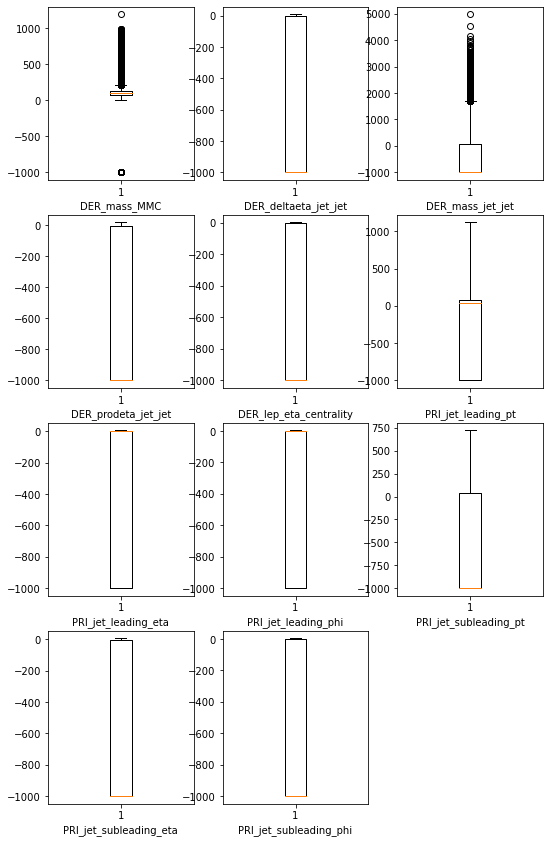

In [13]:
clean_, clean_labels = extract_features_and_labels(tX, labels, to_replace_ind)

plot_feature_boxplots(clean_, clean_labels, 3)

Now that we have all features that need to be cleaned, we will proceed to the cleaning.<br>
**First strategy:** Replace data in `['DER_mass_MMC', 'DER_mass_jet_jet', 'PRI_jet_leading_pt', 'PRI_jet_subleading_pt']` (histograms with a bigger spread) with the median, and use mean for the others (this is not a statistically sound strategy, we should use boxplots to determine which ones need median and which ones don't)

In [14]:
replace_median = ['DER_mass_MMC', 'DER_mass_jet_jet',
                  'PRI_jet_leading_pt', 'PRI_jet_subleading_pt']


In [15]:
def replace_unknown_values(data, labels, replace_median):
    """replace all unknown (`-999.0`) values with the mean, except for features specified by `replace_median`"""
    dat = data.copy()
    for ind, f in enumerate(labels):
        known_values = np.where(dat.T[ind] != -999.0)
        unknown_values = np.where(dat.T[ind] == -999.0)
        col = dat.T[ind, known_values]
        #replace_value = np.median(col) if f in replace_median else np.mean(col)
        replace_value = np.mean(col)
        dat.T[ind, unknown_values] = replace_value
    return dat


**Actual strategy:** The spread seems to be better when we replace all values by the mean of the feature. Something to test.

In [16]:
replaced_ = replace_unknown_values(clean_, clean_labels, replace_median)


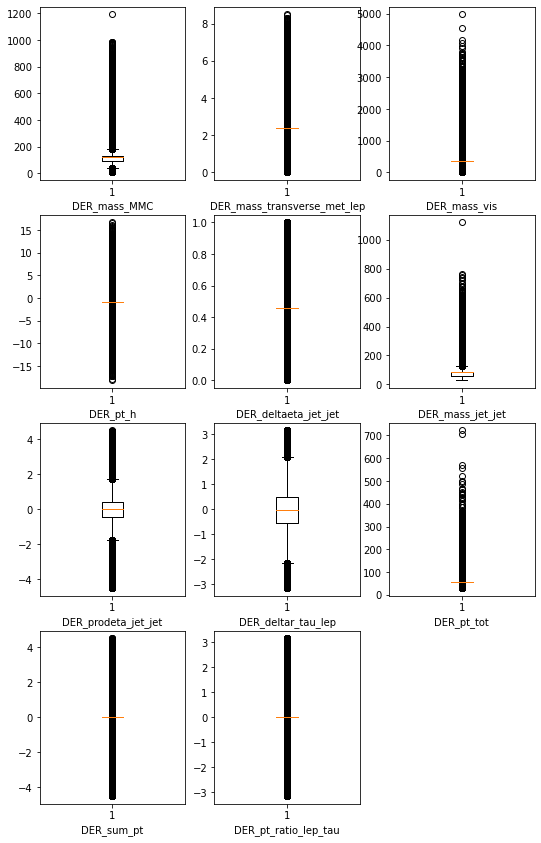

In [17]:
# Check updated boxplots
plot_feature_boxplots(replaced_, labels, 3)

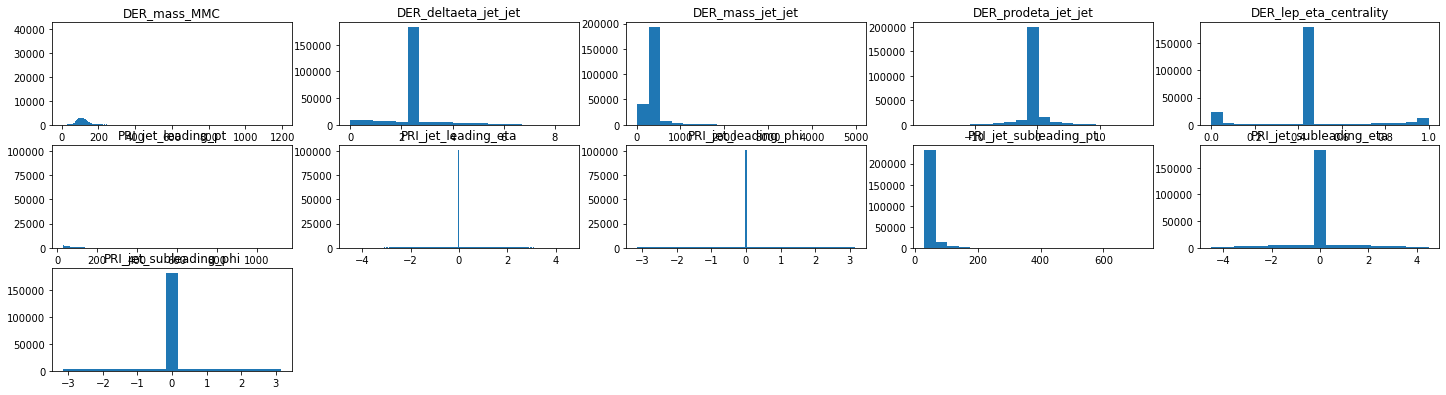

In [18]:
plot_histograms(replaced_, clean_labels, 5)

In [19]:
# Replace updated data in a new X array
cleaned_xt = []
for label in labels:
    if label in clean_labels:
        cleaned_xt.append(replaced_.T[clean_labels.index(label)])
    else:
        cleaned_xt.append(tX.T[ind])

cleaned_x = np.array(cleaned_xt).T
print(cleaned_x.shape)

# Sanity check: in relevant indexes of the data, there should no longer be any unknown values
truth_values = []
for i in jet_cat:
    truth_values.append(np.all(cleaned_x.T[rel_ind[i]] != -999.0))
print('{}: All relevant unknown values have been replaced'.format(np.all(truth_values)))

tx_cats = []
for i in jet_cat:
    subset = tX[np.where(tX[:, lab_dict['PRI_jet_num']] == i)]
    relevant_subset = subset.T[rel_ind[i]]
    tx_cats.append(relevant_subset.T)

# Sanity check: number of features of categories is same as number of relevant features
truth_values = []
for i in jet_cat:
    truth_values.append(len(tx_cats[i].T) == len(rel_ind[i]))
print('{}: New categories have as many features as there are relevant features'.format(np.all(truth_values)))



(250000, 30)
True: All relevant unknown values have been replaced
True: New categories have as many features as there are relevant features


#### Feature engineering

To obtain better results with logistic regression, we proceed with a step of feature processing and engineering.<br>
First, we draw correlation matrices to better understand the correlation between features of a same category.

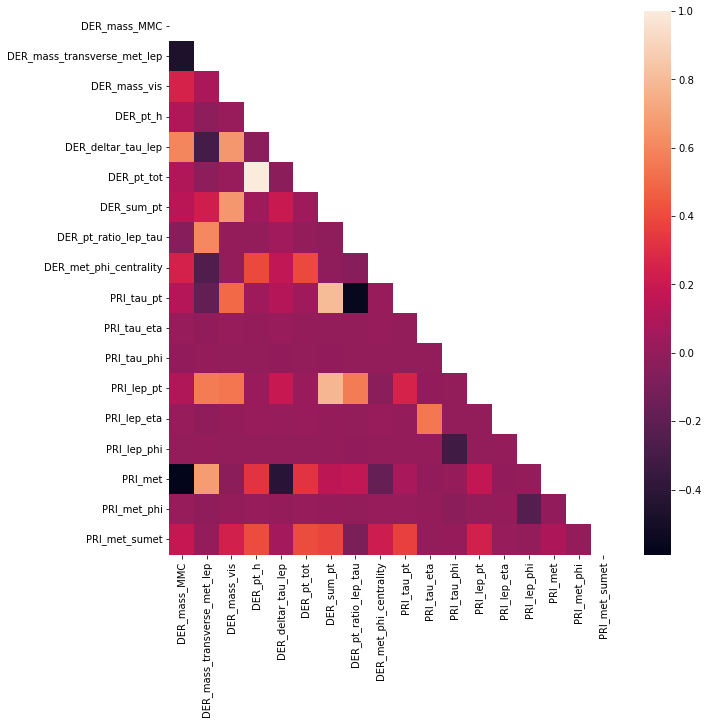

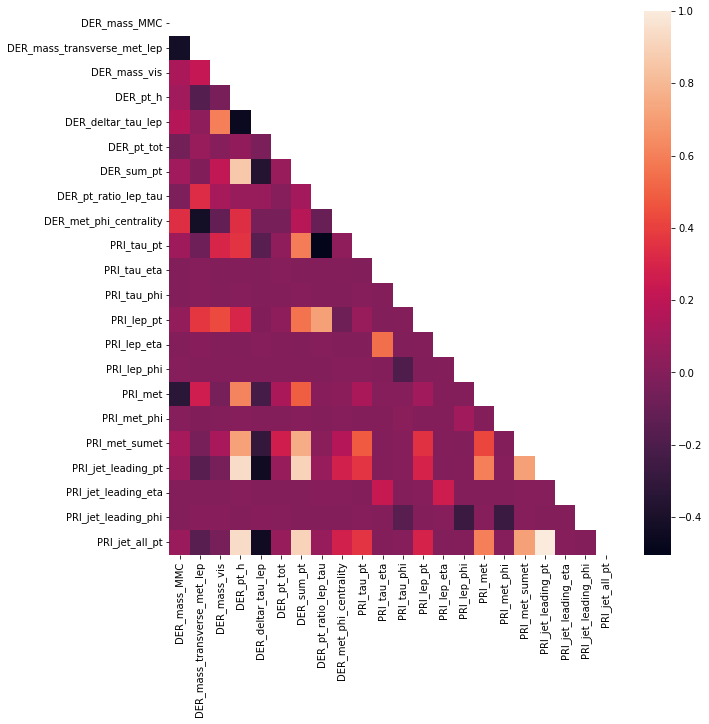

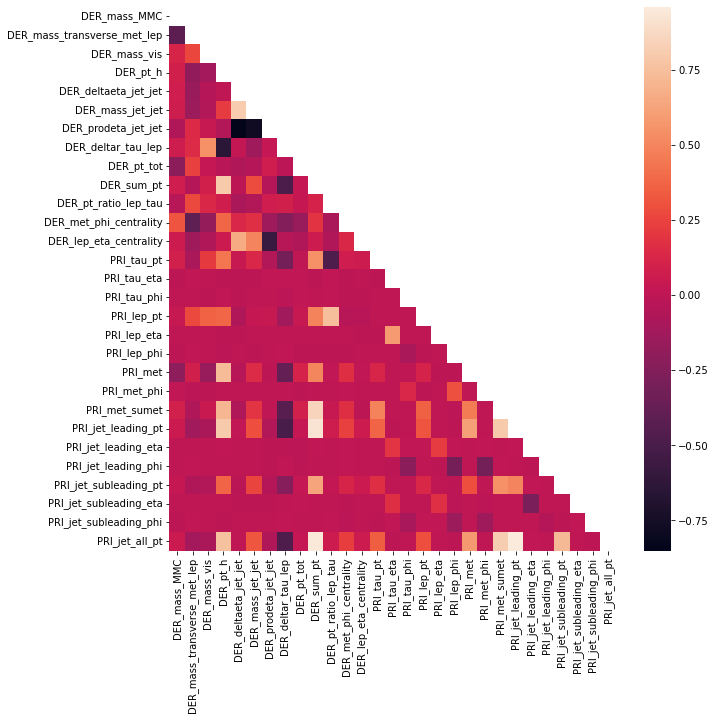

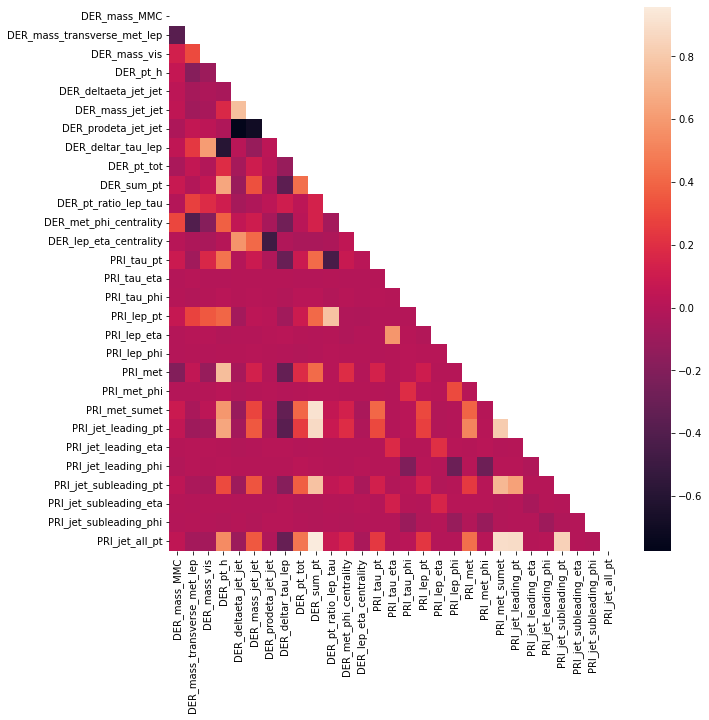

In [20]:
import seaborn as sns

for i in jet_cat:
    n = tx_cats[i].shape[1]
    mask = np.triu(np.ones((n, n)).astype(bool))

    corr = np.corrcoef(tx_cats[i].T)

    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)
    ticks = [labels[l] for l in rel_ind[i]]
    sns.heatmap(corr, xticklabels=ticks, yticklabels=ticks, mask=mask)
    plt.show()

From the correlation heatmaps, we notice that some features have low correlation with all other features (i.e. the line or column is uniformly colored and the color indicates a value close to 0). These low-correlation features can be pairwise multiplied with all other features to engineer new attributes for the model to perform predictions on.

In [21]:
low_corr_features = {
    0: ['PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_phi'],
    1: ['PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_phi',
        'PRI_jet_leading_eta', 'PRI_jet_leading_phi'],
    2: ['PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_phi',
        'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi'],
    3: ['PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_phi',
        'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi'],
}

In [22]:
import itertools as it

def build_final_features(tx_cats):
    final_features = []

    for ind in jet_cat:
        engineered_features = []
        engineered_labels = []
        rel_labels = [labels[rel_ind[ind][j]] for j in range(len(rel_ind[ind]))]

        # Get all 2-combinations of relevant labels
        combinations = it.combinations(rel_labels, 2)
        corr_combinations = [i for i in combinations if i[0] in low_corr_features[ind] or i[1]
                            in low_corr_features]  # Only keep those involving at least one low-correlated feature
        # Now, create all new features and labels by multiplying feature columns elementwise
        for comb in corr_combinations:
            ind1, ind2 = rel_labels.index(comb[0]), rel_labels.index(comb[1])
            engineered_labels.append('{a} * {b}'.format(a=comb[0], b=comb[1]))
            engineered_features.append(tx_cats[ind].T[ind1] * tx_cats[ind].T[ind2])

        engineered_labels = np.array(engineered_labels)
        engineered_features = np.array(engineered_features).T

        # plot_feature_graphs(y_cats[ind], engineered_features, engineered_labels, 10)

        final_features.append(np.hstack((tx_cats[ind], engineered_features)))

    return final_features

final_features = build_final_features(tx_cats)


Now that we have all of our features ready by category, we may proceed to: <br>
- training the model to obtain optimal weights, or
- standardizing the data, or
- doing $\log{(1 + x)}$ on all features (this reduces their scale and ensures that all values are positive)

#### Standardizing the data (does not use final_features)

Now we standardize all features across all categories:

In [23]:
# Note: this code does not contain engineered features

truth_values = []
for i in jet_cat:
    tx_cats[i] = (tx_cats[i] - np.mean(tx_cats[i], axis=0)) / np.std(tx_cats[i], axis=0)
    truth_values.append(np.allclose(0, np.mean(tx_cats[i], axis=0)) and np.allclose(1, np.std(tx_cats[i], axis=0)))

print('{}: Dataset has been standardized'.format(np.all(truth_values)))


True: Dataset has been standardized


#### Training the model

We use cross-validation to determine a good lambda value to train the model:

Lambda value 0 (=1e-06), rmse_tr = 0.7469941851452301, rmse_te = 0.7474480612336201
Lambda value 1 (=1e-05), rmse_tr = 0.7469988532039237, rmse_te = 0.747448137912186


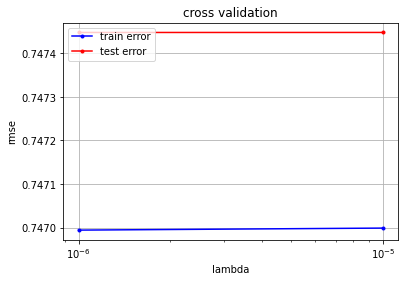

Lambda value 2 (=0.0001), rmse_tr = 0.7470452672900295, rmse_te = 0.7474502052187297


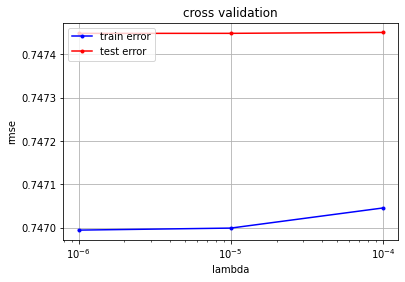

Lambda value 3 (=0.001), rmse_tr = 0.74749063730407, rmse_te = 0.7474897802753762


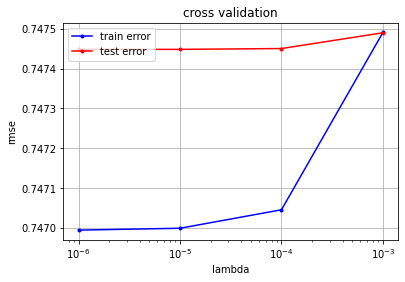

Lambda value 4 (=0.01), rmse_tr = 0.7506375551898168, rmse_te = 0.7487567952716152


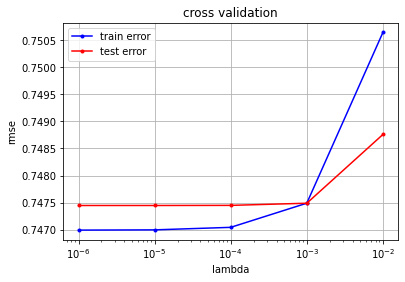

In [24]:
from implementations import cross_validation_demo

ind = 0
lambdas = np.logspace(-6, -2, 5)
cross_validation_demo(y_cats[ind], final_features[ind], 1, 10, 1, lambdas)

Therefore, we choose `lambda_=1e-6`.

In [25]:
from implementations import ridge_regression, logistic_regression, least_squares


weights_arr = []
lambda_ = 1e-6
gamma = 0.01
max_iters = 5

for i in jet_cat:
    initial_w = np.zeros(shape=(final_features[i].shape[1], 1))
    #weights, loss = logistic_regression(y_cats[i], final_features[i], initial_w, max_iters, gamma)
    weights, loss = ridge_regression(y_cats[i], final_features[i], lambda_)
    print('category={i}, rmse={l}'.format(i=i, l=np.sqrt(2*loss)))
    weights_arr.append(weights)

category=0, rmse=0.7470153030022697
category=1, rmse=0.8707119211465815
category=2, rmse=0.8455869182620525
category=3, rmse=0.8475098605413207


### Prediction generation

In [26]:
def filter_relevant_features(tx_cats):
    for ind, cat in enumerate(tx_cats):
        tx_cats[ind] = tx_cats[ind][:, rel_ind[ind]]
        
    return tx_cats


In [27]:
def recombine_data(predictions, original_data):
    """Format predictions as they originally were, i.e. the right prediction at the right row"""
    indexed_predictions = []
    for i in jet_cat:
        indexes = np.where(original_data[:, lab_dict['PRI_jet_num']] == i)[0]
        ind_pred = np.vstack((indexes, predictions[i]))
        indexed_predictions.append(ind_pred)

    indexed_predictions = np.concatenate(indexed_predictions, axis=1)
    sorted_predictions = indexed_predictions.T[np.argsort(
        indexed_predictions.T[:, 0])]
    return sorted_predictions[:, 1]


In [28]:
def predict_category_labels(weights_arr, tX_test):
    """Perform category-wise prediction"""
    _, tx_cats = split_data_by_jet_num(tX_test)
    tx_cats = filter_relevant_features(tx_cats)
    final_features = build_final_features(tx_cats)
    predictions = []
    for ind, cat in enumerate(final_features):
        predictions.append(predict_labels(weights_arr[ind], cat))
        
    return recombine_data(predictions, tX_test)

## Generate predictions and save ouput in csv format for submission:

In [29]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '../output/submission.csv' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights, tX_test)
y_pred = predict_category_labels(weights_arr, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)